In [237]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [238]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [239]:
# Read file to pd dataframe
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
# Get rid of "id" and "product_code"
train = train.iloc[:train.shape[0], 2:train.shape[1]]
test = test.iloc[:test.shape[0], 2:test.shape[1]]
# Shuffle the training data
train = train.reindex(np.random.permutation(train.index))

In [240]:
# Map the value in attribute_0 and attribute_1
attribute_0 = {"material_5": "0", "material_7": "1"}
attribute_1 = {"material_5": "0", "material_6": "1",
               "material_7": "2", "material_8": "3"}
# Replace the value in attribute_0 and attribute_1
train = train.replace({"attribute_0": attribute_0})
train = train.replace({"attribute_1": attribute_1})
test = test.replace({"attribute_0": attribute_0})
test = test.replace({"attribute_1": attribute_1})
# Change the column type from obejct to int
train["attribute_0"] = train["attribute_0"].astype(int)
train["attribute_1"] = train["attribute_1"].astype(int)
test["attribute_0"] = test["attribute_0"].astype(int)
test["attribute_1"] = test["attribute_1"].astype(int)

In [241]:
# Add two new feature base on reference from discussion
train["missing_measure_3"] = train["measurement_3"].isna()
train["missing_measure_5"] = train["measurement_5"].isna()
test["missing_measure_3"] = test["measurement_3"].isna()
test["missing_measure_5"] = test["measurement_5"].isna()
# Fill the Nan value with the average
for i in train.columns:
    null_cols=train[train[i].isna()].index
    for n in null_cols:
        train.loc[n,i]=train[i].mean()
for i in test.columns:
    null_cols = test[test[i].isna()].index
    for n in null_cols:
        test.loc[n,i]=test[i].mean()

In [242]:
# Apply feature engineering from reference in discussion
# Multiply length dimensions to get area. attributes 2 and 3 look like they are width and length dimensions or similar.
# Aggregate measurement_3 to 16 into average and stdev. They look like they belong to the same group.
def mean_3_to_16(row):
    return row.iloc[9:20].mean()

def std_3_to_16(row):
    return row.iloc[9:20].std()

def attri_multi(row):
    return row.iloc[3] * row.iloc[4]

train["measurement_std"] = train.apply(lambda row : std_3_to_16(row), axis = 1)
train['measurement_mean'] = train.apply(lambda row : mean_3_to_16(row), axis = 1)
train['attri_2_attri_3'] = train.apply(lambda row : attri_multi(row), axis = 1)
remain_col = ["loading", "attribute_0", "attribute_1", "attri_2_attri_3", "measurement_0",
              "measurement_1", "measurement_2", "measurement_17", "measurement_mean", "measurement_std", "missing_measure_3", "missing_measure_3", "failure"]
train = train[remain_col]

test["measurement_std"] = test.apply(lambda row: std_3_to_16(row), axis=1)
test['measurement_mean'] = test.apply(lambda row: mean_3_to_16(row), axis=1)
test['attri_2_attri_3'] = test.apply(lambda row: attri_multi(row), axis=1)
remain_col = ["loading", "attribute_0", "attribute_1", "attri_2_attri_3", "measurement_0",
              "measurement_1", "measurement_2", "measurement_17", "measurement_mean", "measurement_std", "missing_measure_3", "missing_measure_3"]
test =test[remain_col]

In [243]:
# Split the feature and target, also into training data and validation data
train_size = 0.9
x_train = train.iloc[:int(train.shape[0] *train_size), :train.shape[1] - 1].values
y_train = train.iloc[:int(train.shape[0] *train_size), train.shape[1] - 1:].values
x_valid = train.iloc[int(train.shape[0] * train_size):, :train.shape[1] - 1].values
y_valid = train.iloc[int(train.shape[0] * train_size):, train.shape[1] - 1:].values

In [245]:
x_train = x_train.tolist()
y_train = y_train.tolist()
x_valid = x_valid.tolist()
y_valid = y_valid.tolist()

In [249]:
def encode_single_sample(features, label):
    features = np.reshape(features, (12,))
    return {"features": features, "label": label}

batch_size = 50
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [250]:
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(units=500, input_dim=12,
          kernel_initializer='he_normal', activation='softsign'))

    model.add(layers.Dense(units=250, activation='softsign'))
    model.add(layers.Dense(units=125, activation='softsign'))
    model.add(layers.Dense(units=62, activation='softsign'))
    model.add(layers.Dense(units=1, activation="softsign"))

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_238 (Dense)           (None, 500)               6500      
                                                                 
 dense_239 (Dense)           (None, 250)               125250    
                                                                 
 dense_240 (Dense)           (None, 125)               31375     
                                                                 
 dense_241 (Dense)           (None, 62)                7812      
                                                                 
 dense_242 (Dense)           (None, 1)                 63        
                                                                 
Total params: 171,000
Trainable params: 171,000
Non-trainable params: 0
_________________________________________________________________


In [251]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
479/479 [==============================] - 2s 4ms/step - loss: 0.1707 - accuracy: 0.7818 - val_loss: 0.1710 - val_accuracy: 0.7787
Epoch 2/100
479/479 [==============================] - 2s 3ms/step - loss: 0.1675 - accuracy: 0.7884 - val_loss: 0.1706 - val_accuracy: 0.7787
Epoch 3/100
479/479 [==============================] - 2s 3ms/step - loss: 0.1671 - accuracy: 0.7884 - val_loss: 0.1705 - val_accuracy: 0.7787
Epoch 4/100
479/479 [==============================] - 2s 3ms/step - loss: 0.1668 - accuracy: 0.7884 - val_loss: 0.1703 - val_accuracy: 0.7787
Epoch 5/100
479/479 [==============================] - 2s 3ms/step - loss: 0.1666 - accuracy: 0.7884 - val_loss: 0.1700 - val_accuracy: 0.7787
Epoch 6/100
479/479 [==============================] - 2s 4ms/step - loss: 0.1666 - accuracy: 0.7884 - val_loss: 0.1701 - val_accuracy: 0.7787
Epoch 7/100
479/479 [==============================] - 2s 4ms/step - loss: 0.1665 - accuracy: 0.7884 - val_loss: 0.1701 - val_accuracy: 0.7787

In [253]:
y_pred = model.predict(test.values.tolist())
y_pred = np.array(y_pred)
y_pred = pd.DataFrame(y_pred, columns= ["failure"])
submission = pd.read_csv("data/sample_submission.csv")
sub = pd.DataFrame({'id': submission.id, 'failure': y_pred.failure})
print(sub)
sub.to_csv("submission.csv", index=False)


650/650 [==============================] - 1s 1ms/step
          id   failure
0      26570  0.257283
1      26571  0.257393
2      26572  0.247772
3      26573  0.249827
4      26574  0.314535
...      ...       ...
20770  47340  0.256066
20771  47341  0.188339
20772  47342  0.158342
20773  47343  0.221618
20774  47344  0.195976

[20775 rows x 2 columns]


<AxesSubplot:>

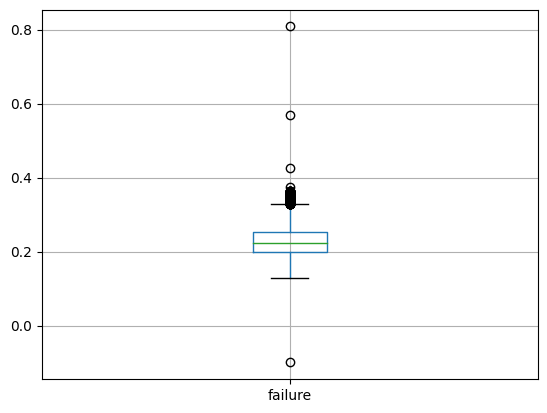

In [254]:
y = pd.DataFrame(y_pred)
y.boxplot()